#Finetune Recurrent Neural Network with GridSearch() class


###Reference

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

###Mounting to Google Drive


In [ ]:
#connecting gdrive into the google colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Import Libraries

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import Activation, Dense, Dropout, Flatten, SimpleRNN
from keras.constraints import max_norm
from tensorflow.keras import layers

from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

####Load the Dataset


In [ ]:
# change file path accordingly 
data=pd.read_csv("/content/gdrive/MyDrive/Depression Project/DepressionDataFinal2Processed.csv")
data = data.astype(str)
data.head()

,Id,Text,Target
0,2.85e+17,one thing love life mother one ever come mine,1
1,2.9e+17,want perfect want happy,0
2,2.86e+17,mom hates dad hates today sucks fword life tho,0
3,2.86e+17,hate hate life,0
4,2.86e+17,feel good,1


In [ ]:
data.columns

Index(['Id', 'Text', 'Target'], dtype='object')

### Train, Val, Test split --> 60%, 20%, 20% 

In [ ]:
# x_train is the training data set
# y_train is the corresponding labels to x_train 
# x_test is the test dataset 
# y_test is the corresponding label to x_test 
x_train, x_test, y_train, y_test = train_test_split(data, data.Target, test_size=0.2, random_state=1)
# 0.25 x 0.8 = 0.2
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) 

### Find Maximum Length of Tweets - max_len constant



In [ ]:
# find maximum length of tweet
def max_len(x):
    a=x.split()
    return len(a)

max(data['Text'].apply(max_len))

20

In [ ]:
# maxlen = 20 --> maximum length of tweet = 20
max_len = 20

### Convert Label into Term-Document Matrix

In [ ]:
# Bag of Words used to one-hot encode Target label 
# use CountVectorizer to covert the label into tokens
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(","), binary='true')
y_train=vectorizer.fit_transform(x_train['Target']).toarray()
y_test=vectorizer.fit_transform(x_test['Target']).toarray()
y_val=vectorizer.fit_transform(x_val['Target']).toarray()

### Tokenize tweets using Tokenizer()

In [ ]:
vect=Tokenizer()
vect.fit_on_texts(data['Text'])

### Find Size of Vectorized Tokens  - vocab_size constant



In [ ]:
vocab_size = len(vect.word_index) + 1
print(vocab_size)

1989


### Turn the Vectorized Tokens into Sequences of Integers


In [ ]:
encoded_docs_train = vect.texts_to_sequences(x_train['Text'])
encoded_docs_test =  vect.texts_to_sequences(x_test['Text'])
encoded_docs_cv = vect.texts_to_sequences(x_val['Text'])

### Padding and Making all the Sequences the same Length

In [ ]:
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=max_len, padding='post')
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=max_len, padding='post')
padded_docs_cv = pad_sequences(encoded_docs_cv, maxlen=max_len, padding='post')

## Find Optimum Epoch and Batch Size 

In [ ]:
# Use scikit-learn to grid search the batch size and epochs
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# Function to create model, required for KerasClassifier
def create_model():
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.SimpleRNN(32))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
	# Compile model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model
# create model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [64, 128, 256, 512, 1024]
epochs = [25]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.898090 using {'batch_size': 64, 'epochs': 25}
0.898090 (0.002331) with: {'batch_size': 64, 'epochs': 25}
0.895443 (0.009103) with: {'batch_size': 128, 'epochs': 25}
0.893175 (0.008053) with: {'batch_size': 256, 'epochs': 25}
0.894876 (0.002551) with: {'batch_size': 512, 'epochs': 25}
0.867272 (0.026080) with: {'batch_size': 1024, 'epochs': 25}


## Tune Optimisation Algorithm 

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.SimpleRNN(32))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
  # Compile model 
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  return model
# create model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.898279 using {'optimizer': 'Nadam'}
0.826999 (0.011871) with: {'optimizer': 'SGD'}
0.894876 (0.002551) with: {'optimizer': 'RMSprop'}
0.575912 (0.044044) with: {'optimizer': 'Adagrad'}
0.509737 (0.031031) with: {'optimizer': 'Adadelta'}
0.890717 (0.003772) with: {'optimizer': 'Adam'}
0.890528 (0.006021) with: {'optimizer': 'Adamax'}
0.898279 (0.005525) with: {'optimizer': 'Nadam'}


## Tune Neuron Activation Function


In [ ]:
def create_model(activation='relu'):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.SimpleRNN(32))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='sigmoid'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
# create model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.893931 using {'activation': 'sigmoid'}
0.868217 (0.017855) with: {'activation': 'softmax'}
0.884666 (0.003084) with: {'activation': 'softplus'}
0.889960 (0.007279) with: {'activation': 'softsign'}
0.883721 (0.011230) with: {'activation': 'relu'}
0.878616 (0.017507) with: {'activation': 'tanh'}
0.893931 (0.005913) with: {'activation': 'sigmoid'}
0.877482 (0.009123) with: {'activation': 'hard_sigmoid'}
0.890906 (0.010203) with: {'activation': 'linear'}


## Tune Learning Rate and Momentum

In [ ]:
def create_model(learn_rate=0.01, momentum=0):
  # create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.SimpleRNN(32))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
  return model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.894120 using {'learn_rate': 0.01, 'momentum': 0.9}
0.890149 (0.006653) with: {'learn_rate': 0.001, 'momentum': 0.0}
0.882586 (0.009251) with: {'learn_rate': 0.001, 'momentum': 0.2}
0.880885 (0.010346) with: {'learn_rate': 0.001, 'momentum': 0.4}
0.855360 (0.017073) with: {'learn_rate': 0.001, 'momentum': 0.6}
0.886746 (0.012044) with: {'learn_rate': 0.001, 'momentum': 0.8}
0.879183 (0.009366) with: {'learn_rate': 0.001, 'momentum': 0.9}
0.871809 (0.009901) with: {'learn_rate': 0.01, 'momentum': 0.0}
0.893175 (0.007239) with: {'learn_rate': 0.01, 'momentum': 0.2}
0.881263 (0.007918) with: {'learn_rate': 0.01, 'momentum': 0.4}
0.876158 (0.017698) with: {'learn_rate': 0.01, 'momentum': 0.6}
0.889393 (0.015616) with: {'learn_rate': 0.01, 'momentum': 0.8}
0.894120 (0.008053) with: {'learn_rate': 0.01, 'momentum': 0.9}
0.885423 (0.001389) with: {'learn_rate': 0.1, 'momentum': 0.0}
0.885612 (0.009828) with: {'learn_rate': 0.1, 'momentum': 0.2}
0.869351 (0.002978) with: {'learn_rate': 

## Tune Dropout Regularization

In [ ]:
def create_model(dropout_rate=0.0, weight_constraint=0):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.SimpleRNN(32))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='softmax'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train, validation_data = (padded_docs_cv, y_val))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.898469 using {'dropout_rate': 0.1, 'weight_constraint': 2}
0.870675 (0.022293) with: {'dropout_rate': 0.0, 'weight_constraint': 1}
0.886746 (0.005408) with: {'dropout_rate': 0.0, 'weight_constraint': 2}
0.875969 (0.004151) with: {'dropout_rate': 0.0, 'weight_constraint': 3}
0.875402 (0.006423) with: {'dropout_rate': 0.0, 'weight_constraint': 4}
0.878994 (0.009266) with: {'dropout_rate': 0.0, 'weight_constraint': 5}
0.876914 (0.005634) with: {'dropout_rate': 0.1, 'weight_constraint': 1}
0.898469 (0.004835) with: {'dropout_rate': 0.1, 'weight_constraint': 2}
0.888637 (0.007195) with: {'dropout_rate': 0.1, 'weight_constraint': 3}
0.886557 (0.003676) with: {'dropout_rate': 0.1, 'weight_constraint': 4}
0.857629 (0.028319) with: {'dropout_rate': 0.1, 'weight_constraint': 5}
0.887124 (0.016947) with: {'dropout_rate': 0.2, 'weight_constraint': 1}
0.875969 (0.013216) with: {'dropout_rate': 0.2, 'weight_constraint': 2}
0.887881 (0.002331) with: {'dropout_rate': 0.2, 'weight_constraint': 

## Tune Network Weight Initialization

In [ ]:
def create_model(init_mode= 'uniform'):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.SimpleRNN(32))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='softmax', kernel_initializer=init_mode))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=128, verbose=0)
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.886557 using {'init_mode': 'glorot_uniform'}
0.867839 (0.016903) with: {'init_mode': 'uniform'}
0.882019 (0.012112) with: {'init_mode': 'lecun_uniform'}
0.878049 (0.014704) with: {'init_mode': 'normal'}
0.865570 (0.028144) with: {'init_mode': 'zero'}
0.878805 (0.010534) with: {'init_mode': 'glorot_normal'}
0.886557 (0.005634) with: {'init_mode': 'glorot_uniform'}
0.877482 (0.014439) with: {'init_mode': 'he_normal'}
0.862356 (0.015404) with: {'init_mode': 'he_uniform'}


## Tune the Number of Neurons in the Hidden Layer

In [ ]:
def create_model(neurons=1):
	# create model
  model = Sequential()
  # Configuring the parameters
  model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
  model.add(layers.SimpleRNN(32))
  model.add(Dropout(0.2))
  # Adding a dense output layer with sigmoid activation
  model.add(Dense(2, activation='softmax', kernel_initializer='he_uniform'))
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
	# Compile model
  return model
model = KerasClassifier(build_fn=create_model, epochs=25, batch_size=128, verbose=0)
# define the grid search parameters
neurons = [25, 30, 35, 40, 45, 50, 100]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(padded_docs_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.887313 using {'neurons': 30}
0.881641 (0.014441) with: {'neurons': 25}
0.887313 (0.002331) with: {'neurons': 30}
0.884477 (0.009278) with: {'neurons': 35}
0.872188 (0.023635) with: {'neurons': 40}
0.885044 (0.005267) with: {'neurons': 45}
0.878049 (0.003791) with: {'neurons': 50}
0.872188 (0.018951) with: {'neurons': 100}


### Build and compile DL Model

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.4)
model = Sequential()
# Configuring the parameters
model.add(Embedding(vocab_size, output_dim=50, input_length=max_len))
model.add(layers.SimpleRNN(40, kernel_constraint=max_norm(2)))
model.add(Dropout(0.6))
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(2, activation='softmax', kernel_initializer='zero'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 20, 50)            99450     
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 40)                3640      
_________________________________________________________________
dropout_10 (Dropout)         (None, 40)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 82        
Total params: 103,172
Trainable params: 103,172
Non-trainable params: 0
_________________________________________________________________


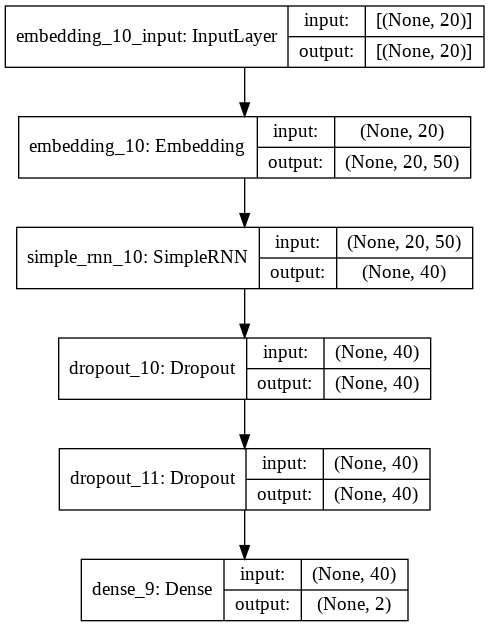

In [ ]:
# plot NN model 
plot_model(model, to_file='/content/gdrive/MyDrive/Depression Project/mlp-mnist.png', show_shapes=True)

In [ ]:
# compile the model 

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(padded_docs_train, y_train,
                    epochs=25, batch_size=128, 
                    validation_data = (padded_docs_cv, y_val)
                    )

Epoch 1/25
42/42 [==============================] - 2s 21ms/step - loss: 0.1701 - accuracy: 0.9382 - val_loss: 0.2804 - val_accuracy: 0.8990
Epoch 2/25
42/42 [==============================] - 1s 17ms/step - loss: 0.1566 - accuracy: 0.9600 - val_loss: 0.2988 - val_accuracy: 0.9172
Epoch 3/25
42/42 [==============================] - 1s 17ms/step - loss: 0.1442 - accuracy: 0.9607 - val_loss: 0.2395 - val_accuracy: 0.9166
Epoch 4/25
42/42 [==============================] - 1s 17ms/step - loss: 0.1351 - accuracy: 0.9627 - val_loss: 0.2578 - val_accuracy: 0.9217
Epoch 5/25
42/42 [==============================] - 1s 16ms/step - loss: 0.1136 - accuracy: 0.9659 - val_loss: 0.2938 - val_accuracy: 0.9234
Epoch 6/25
42/42 [==============================] - 1s 17ms/step - loss: 0.1075 - accuracy: 0.9688 - val_loss: 0.2260 - val_accuracy: 0.9234
Epoch 7/25
42/42 [==============================] - 1s 16ms/step - loss: 0.1149 - accuracy: 0.9627 - val_loss: 0.6325 - val_accuracy: 0.7272
Epoch 8/25
42

### Evaluate the Model


In [ ]:
model.evaluate(padded_docs_test, y_test)

56/56 [==============================] - 0s 3ms/step - loss: 0.3458 - accuracy: 0.9126


[0.3457737863063812, 0.9126489162445068]

### Plot Results in a Graph 

In [ ]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

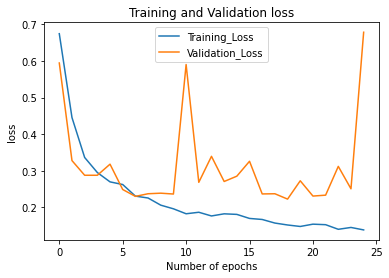

In [ ]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

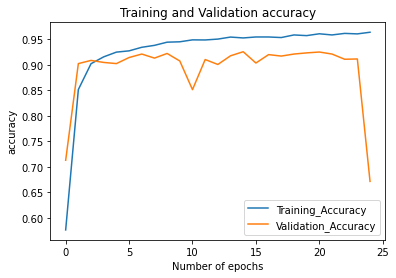

In [ ]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')